In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# prompt: Load csv file with pandas
import pandas as pd
df = pd.read_csv('/content/asv_interpretability_dataset_modified.csv', dtype={'PatientID': str})

In [ ]:
# --- Handle NeutrophilCount with '<0.1' values ---
def parse_neutrophil(value):
    try:
        return float(value)
    except:
        if isinstance(value, str) and "<" in value:
            threshold = float(value.replace("<", "").strip())
            return threshold / 2  # or use threshold itself
        return np.nan

df['NeutrophilCount'] = df['NeutrophilCount'].apply(parse_neutrophil)

In [ ]:
# One-hot encode stool consistency
df = pd.get_dummies(df, columns=['Consistency'])

In [ ]:
# Log transform Genus-relative abundances
df['RelativeAbundance'] = df['RelativeAbundance'].astype(float)
df['RelativeAbundance'] = np.log1p(df['RelativeAbundance'])

# Creating the Proxy Labels



In [ ]:
# Newly added section for testing - ground truth label
def label_dysbiosis(row):
    is_temp_abnormal = row['MaxTemperature'] > 38.0
    is_neutro_low = row['NeutrophilCount'] < 500
    is_consistency_liquid = row.get('Consistency_liquid', 0) == 1
    return int(is_temp_abnormal and is_neutro_low and is_consistency_liquid)

In [ ]:
df['DysbiosisLabel'] = df.apply(label_dysbiosis, axis=1)

In [ ]:
# Keep metadata along with abundances
metadata_cols = ['PatientID', 'SampleID', 'DayRelativeToNearestHCT',
                 'MaxTemperature', 'NeutrophilCount'] + \
                [col for col in df.columns if col.startswith('Consistency_')] + \
                ['DysbiosisLabel']

In [ ]:
# Pivot genus into columns (wide format)
genus_pivot = df.pivot_table(index=['PatientID', 'SampleID', 'DayRelativeToNearestHCT'],
                              columns='Genus', values='RelativeAbundance', fill_value=0).reset_index()

In [ ]:
# # Merge metadata back in
# metadata = df.drop_duplicates(subset=['SampleID'])[['SampleID', 'MaxTemperature', 'NeutrophilCount'] +
#                                                     [col for col in df.columns if 'Consistency_' in col]]
# merged_df = pd.merge(genus_pivot, metadata, on='SampleID', how='left')

In [ ]:
# Merge with metadata
metadata = df[metadata_cols].drop_duplicates(subset=['PatientID', 'SampleID', 'DayRelativeToNearestHCT'])
merged_df = pd.merge(genus_pivot, metadata, on=['PatientID', 'SampleID', 'DayRelativeToNearestHCT'], how='left')

In [ ]:
# Drop genus columns with zero variance
genus_cols = df['Genus'].unique().tolist()
variances = merged_df[genus_cols].var()
non_zero_var_cols = variances[variances > 1e-6].index.tolist()

In [ ]:
# Final feature set
feature_cols = non_zero_var_cols + ['MaxTemperature', 'NeutrophilCount'] + \
               [col for col in merged_df.columns if 'Consistency' in col]

In [ ]:
# ==================== STEP 2: Scaling ====================
scaler = MinMaxScaler()
merged_df[feature_cols] = scaler.fit_transform(merged_df[feature_cols])

In [ ]:
# ==================== STEP 3: Prepare Time Series ====================
# Sort & reshape by patient and day
merged_df = merged_df.sort_values(['PatientID', 'DayRelativeToNearestHCT'])

In [ ]:
# --- [1] Build sequences with labels ---
def build_sequences_with_labels(df, feature_cols, label_col='DysbiosisLabel', seq_len=14):
    X_sequences = []
    y_labels = []
    time_indices = []

    for pid, group in df.groupby('PatientID'):
        group = group.sort_values('DayRelativeToNearestHCT')
        values = group[feature_cols].values
        labels = group[label_col].values
        days = group['DayRelativeToNearestHCT'].values

        for i in range(len(values) - seq_len + 1):
            seq = values[i:i+seq_len]
            label_window = labels[i:i+seq_len]
            label = int(label_window.max())  # 1 if any point in window is dysbiotic
            time = days[i+seq_len-1]  # assign the last day of the window
            X_sequences.append(seq)
            y_labels.append(label)
            time_indices.append((pid, time))

    return np.array(X_sequences), np.array(y_labels), time_indices

In [ ]:
# --- [2] Define features ---
seq_len = 14
feature_cols = [col for col in merged_df.columns
                if col not in ['PatientID', 'SampleID', 'DayRelativeToNearestHCT',
                               'DysbiosisLabel', 'MaxTemperature', 'NeutrophilCount']
                and not col.startswith('Consistency_')]

# --- [3] Build sequences ---
X_seq, y_seq, time_idx = build_sequences_with_labels(merged_df, feature_cols, seq_len=seq_len)

In [ ]:
# --- [4] Create DataFrame for temporal splitting ---
split_df = pd.DataFrame(time_idx, columns=['PatientID', 'DayRelativeToNearestHCT'])
split_df['y'] = y_seq
split_df['X_idx'] = range(len(X_seq))

In [ ]:
# --- [5] Sort by patient and time ---
split_df = split_df.sort_values(['PatientID', 'DayRelativeToNearestHCT'])

# Time-based Splitting

In [ ]:
# --- [6] Determine split indices (70/15/15 by number of sequences) ---
n_total = len(split_df)
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)

In [ ]:
train_idx = split_df.iloc[:n_train]['X_idx'].values
val_idx = split_df.iloc[n_train:n_train+n_val]['X_idx'].values
test_idx = split_df.iloc[n_train+n_val:]['X_idx'].values

In [ ]:
# --- [7] Final splits ---
X_train, y_train = X_seq[train_idx], y_seq[train_idx]
X_val, y_val = X_seq[val_idx], y_seq[val_idx]
X_test, y_test = X_seq[test_idx], y_seq[test_idx]

In [ ]:
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Train: (49781, 14, 412), Validation: (10667, 14, 412), Test: (10669, 14, 412)


In [ ]:
# Filter X_train to only include normal samples (where y_train is 0)
X_train_normal = X_train[y_train == 0]

In [ ]:
timesteps = X_train_normal.shape[1]
n_features = X_train_normal.shape[2]

print(f"Timesteps: {timesteps}, Features: {n_features}")

Timesteps: 14, Features: 412


# Isolation Forest


Isolation Forest Classification Report:
              precision    recall  f1-score   support

      Normal       0.58      0.99      0.73      6159
     Anomaly       0.59      0.01      0.03      4510

    accuracy                           0.58     10669
   macro avg       0.58      0.50      0.38     10669
weighted avg       0.58      0.58      0.43     10669

Isolation Forest ROC AUC: 0.7464
Isolation Forest PR AUC: 0.6213


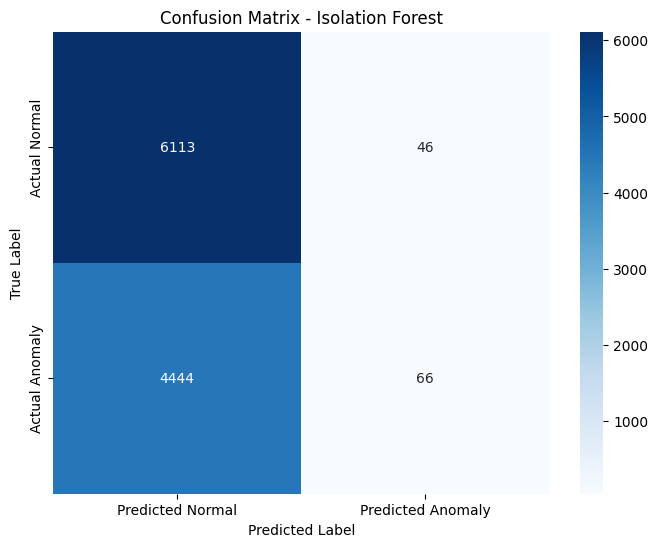

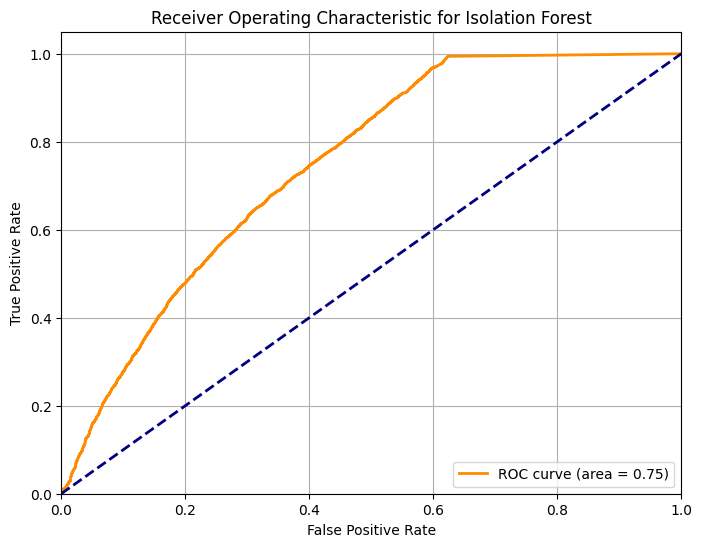

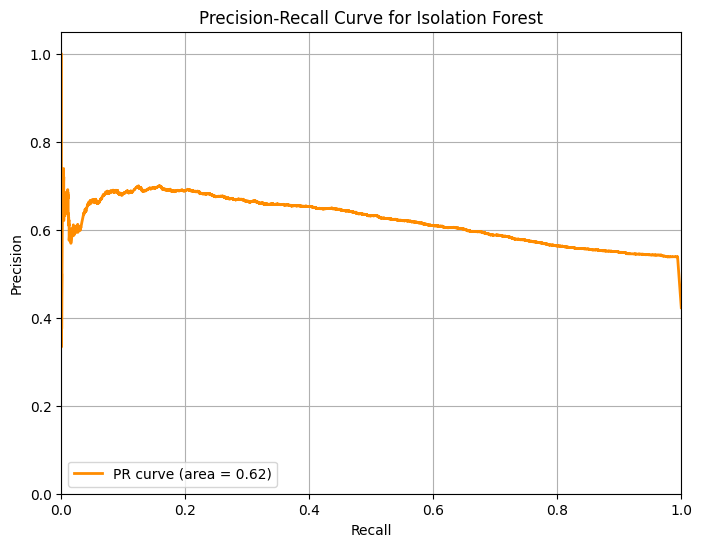

In [ ]:
## Isolation Forest

from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix # Import confusion_matrix
import seaborn as sns # Import seaborn
import numpy as np

# --- 1. Reshape Data for Isolation Forest ---
# Isolation Forest expects a 2D array (n_samples, n_features)
# We need to flatten the time series sequences into a single long feature vector per sequence
n_samples_train = X_train_normal.shape[0]
n_samples_test = X_test.shape[0]
n_features_flattened = X_train_normal.shape[1] * X_train_normal.shape[2]

X_train_normal_flat = X_train_normal.reshape(n_samples_train, n_features_flattened)
X_test_flat = X_test.reshape(n_samples_test, n_features_flattened)


# --- 2. Train Isolation Forest ---
# Train on the normal training data
# 'contamination' is the expected proportion of outliers in the training data
# You might need to tune this or other parameters like n_estimators
iso_forest = IsolationForest(n_estimators=200, contamination='auto', random_state=42, n_jobs=-1)
iso_forest.fit(X_train_normal_flat)


# --- 3. Predict Anomaly Scores and Labels on Test Data ---
# decision_function returns anomaly scores: lower is more anomalous
anomaly_scores_if = iso_forest.decision_function(X_test_flat)

# predict returns -1 for outliers and 1 for inliers
# We'll convert this to 1 for anomalies and 0 for normal for consistency with y_test
anomaly_predictions_if = (iso_forest.predict(X_test_flat) == -1).astype(int)


# --- 4. Evaluate Performance ---
print("\nIsolation Forest Classification Report:")
# target_names can be added if you want specific names for classes 0 and 1
print(classification_report(y_test, anomaly_predictions_if, target_names=["Normal", "Anomaly"], zero_division=1))

# Compute ROC AUC (use negative scores as higher scores from decision_function are less anomalous)
roc_auc_if = roc_auc_score(y_test, -anomaly_scores_if)
print(f"Isolation Forest ROC AUC: {roc_auc_if:.4f}")

# Compute Average Precision (PR AUC) (use negative scores)
average_precision_if = average_precision_score(y_test, -anomaly_scores_if)
print(f"Isolation Forest PR AUC: {average_precision_if:.4f}")


# --- 5. Plotting (Optional but Recommended) ---

# Calculate Confusion Matrix for Isolation Forest
cm_if = confusion_matrix(y_test, anomaly_predictions_if)

# Draw Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_if, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted Normal', 'Predicted Anomaly'],
            yticklabels=['Actual Normal', 'Actual Anomaly'])
plt.title('Confusion Matrix - Isolation Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Plot ROC curve
fpr_if, tpr_if, _ = roc_curve(y_test, -anomaly_scores_if) # Use negative scores

plt.figure(figsize=(8, 6))
plt.plot(fpr_if, tpr_if, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_if:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Isolation Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Plot Precision-Recall curve
precision_if, recall_if, _ = precision_recall_curve(y_test, -anomaly_scores_if) # Use negative scores

plt.figure(figsize=(8, 6))
plt.plot(recall_if, precision_if, color='darkorange', lw=2, label=f'PR curve (area = {average_precision_if:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Isolation Forest')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

# Local Outlier Factor


Local Outlier Factor Classification Report:
              precision    recall  f1-score   support

      Normal       0.78      0.61      0.68      6159
     Anomaly       0.59      0.77      0.67      4510

    accuracy                           0.68     10669
   macro avg       0.69      0.69      0.68     10669
weighted avg       0.70      0.68      0.68     10669

Local Outlier Factor ROC AUC: 0.2745
Local Outlier Factor PR AUC: 0.3077


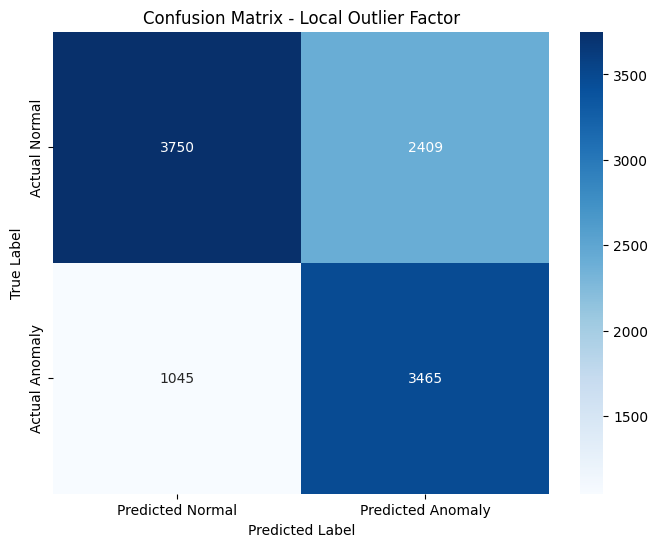

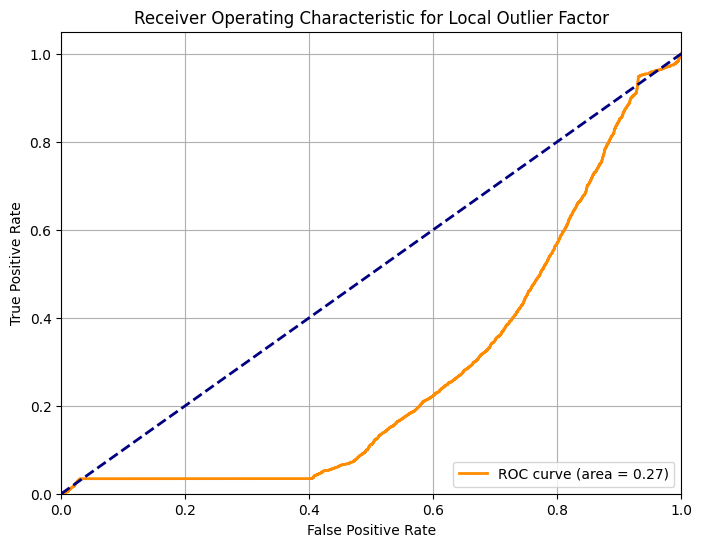

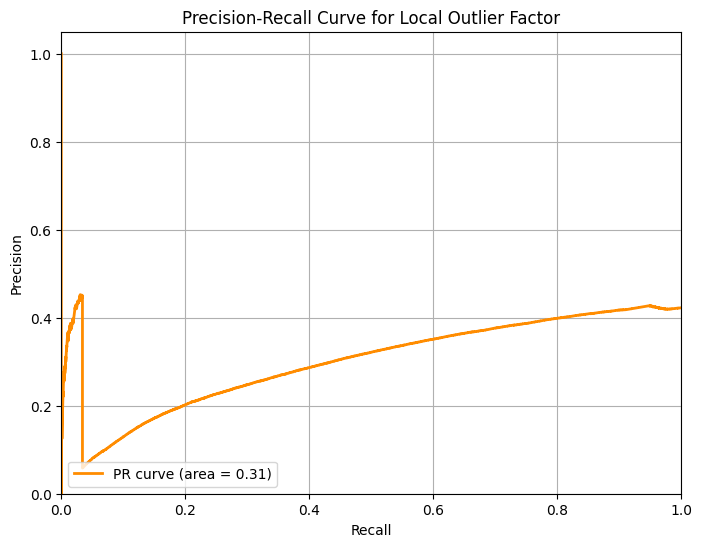

In [ ]:
## Local Outlier Factor (LOF)

from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix # Import confusion_matrix
import seaborn as sns # Import seaborn
import numpy as np

# --- 1. Reshape Data for LOF ---
# Like Isolation Forest, LOF expects a 2D array
n_samples_train = X_train.shape[0] # LOF can be trained on both normal and anomalous data
n_samples_test = X_test.shape[0]
n_features_flattened = X_train.shape[1] * X_train.shape[2]

X_train_flat = X_train.reshape(n_samples_train, n_features_flattened)
X_test_flat = X_test.reshape(n_samples_test, n_features_flattened)


# --- 2. Train LOF ---
# n_neighbors is the number of neighbors to consider
# contamination is similar to Isolation Forest
# novelty=True is required for predicting on new data (the test set)
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto', novelty=True, n_jobs=-1)

# Fit on the training data (can be trained on the full training set)
lof.fit(X_train_flat)


# --- 3. Predict Anomaly Scores and Labels on Test Data ---
# decision_function returns anomaly scores: higher is more anomalous (opposite of Isolation Forest)
anomaly_scores_lof = lof.decision_function(X_test_flat)

# predict returns -1 for outliers and 1 for inliers
anomaly_predictions_lof = (lof.predict(X_test_flat) == -1).astype(int)


# --- 4. Evaluate Performance ---
print("\nLocal Outlier Factor Classification Report:")
print(classification_report(y_test, anomaly_predictions_lof, target_names=["Normal", "Anomaly"], zero_division=1))

# Compute ROC AUC (use positive scores as higher scores from decision_function are more anomalous)
roc_auc_lof = roc_auc_score(y_test, anomaly_scores_lof)
print(f"Local Outlier Factor ROC AUC: {roc_auc_lof:.4f}")

# Compute Average Precision (PR AUC) (use positive scores)
average_precision_lof = average_precision_score(y_test, anomaly_scores_lof)
print(f"Local Outlier Factor PR AUC: {average_precision_lof:.4f}")


# --- 5. Plotting (Optional but Recommended) ---

# Calculate Confusion Matrix for LOF
cm_lof = confusion_matrix(y_test, anomaly_predictions_lof)

# Draw Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lof, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted Normal', 'Predicted Anomaly'],
            yticklabels=['Actual Normal', 'Actual Anomaly'])
plt.title('Confusion Matrix - Local Outlier Factor')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Plot ROC curve
fpr_lof, tpr_lof, _ = roc_curve(y_test, anomaly_scores_lof) # Use positive scores

plt.figure(figsize=(8, 6))
plt.plot(fpr_lof, tpr_lof, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_lof:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Local Outlier Factor')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Plot Precision-Recall curve
precision_lof, recall_lof, _ = precision_recall_curve(y_test, anomaly_scores_lof) # Use positive scores

plt.figure(figsize=(8, 6))
plt.plot(recall_lof, precision_lof, color='darkorange', lw=2, label=f'PR curve (area = {average_precision_lof:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Local Outlier Factor')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()